# _Who has a voice in the media?_
## Clustering

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from qwikidata.linked_data_interface import get_entity_dict_from_api
import json
import pickle
from nltk.corpus import wordnet as wn
import nltk
_ = nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 1. Download and pre-process the dataset of speakers

#### 1.1 Download

In [3]:
# Download the dataset containing the unique speakers of all quotations in Quotebank phase E
# speakers = pd.read_csv('data/speakers.bz2', compression='bz2')
speakers = pd.read_json('data/speakers.json.bz2', compression='bz2')
# speakers.set_index('id', inplace=True)
print(speakers.shape)
speakers.head(2)

(691122, 16)


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion,n_unique_quotes,n_quotes
Q270316,"[Cynthia Jeanne Bowers, C. Jeanne Shaheen]",[+1947-01-28T00:00:00Z],[Q30],[Q6581072],1393026432,None,S001181,[Q82955],[Q29552],None,Jeanne Shaheen,None,item,[Q23540],4094,21060
Q1253,"[Ban Kimoon, Ban Ki Moon]",[+1944-06-13T00:00:00Z],[Q884],[Q6581097],1384825460,[Q484464],None,"[Q82955, Q193391]",[Q327591],None,Ban Ki-moon,None,item,"[Q9581, Q748]",12746,94704


In [24]:
print(f'The percentage of speakers with gender is {100 * (1 - speakers.gender.isnull().sum() / len(speakers.index)):.3f}%')
print(f'The percentage of speakers with occupation is {100 * (1 - speakers.occupation.isnull().sum() / len(speakers.index)):.3f}%')
print(f'The percentage of speakers with date_of_birth is {100 * (1 - speakers.date_of_birth.isnull().sum() / len(speakers.index)):.3f}%')
print(f'The percentage of speakers with nationality is {100 * (1 - speakers.nationality.isnull().sum() / len(speakers.index)):.3f}%')
print(f'The percentage of speakers with party is {100 * (1 - speakers.party.isnull().sum() / len(speakers.index)):.3f}%')
print(f'The percentage of speakers with religion is {100 * (1 - speakers.religion.isnull().sum() / len(speakers.index)):.3f}%')
print(f'The percentage of speakers with US_congress_bio_ID is {100 * (1 - speakers.US_congress_bio_ID.isnull().sum() / len(speakers.index)):.3f}%')
print(f'The percentage of speakers with candidacy is {100 * (1 - speakers.candidacy.isnull().sum() / len(speakers.index)):.3f}%')
print(f'The percentage of speakers with ethnic_group is {100 * (1 - speakers.ethnic_group.isnull().sum() / len(speakers.index)):.3f}%')
print(f'The percentage of speakers with academic_degree is {100 * (1 - speakers.academic_degree.isnull().sum() / len(speakers.index)):.3f}%')

The percentage of speakers with gender is 95.598%
The percentage of speakers with occupation is 93.079%
The percentage of speakers with date_of_birth is 76.902%
The percentage of speakers with nationality is 72.437%
The percentage of speakers with party is 8.964%
The percentage of speakers with religion is 3.036%
The percentage of speakers with US_congress_bio_ID is 0.226%
The percentage of speakers with candidacy is 1.186%
The percentage of speakers with ethnic_group is 2.536%
The percentage of speakers with academic_degree is 1.108%


#### 1.2 Drop columns
Drop the columns that don't add value to clustering (e.g. speaker name) and other attributes present in less than 50% of the speakers

In [4]:
# Drop the columns that don't add value to clustering (e.g. speaker name) and other attributes present in less than 50% of the speakers
speakers_dropped = speakers.drop(columns=['aliases', 'label', 'US_congress_bio_ID', 
                                          'lastrevid', 'type', 
                                          'candidacy', 'academic_degree',
                                          'religion',
                                          'ethnic_group', 'party']).dropna(axis=0)
print(speakers_dropped.shape)
speakers_dropped.head(2)

(442811, 6)


,date_of_birth,nationality,gender,occupation,n_unique_quotes,n_quotes
Q270316,[+1947-01-28T00:00:00Z],[Q30],[Q6581072],[Q82955],4094,21060
Q1253,[+1944-06-13T00:00:00Z],[Q884],[Q6581097],"[Q82955, Q193391]",12746,94704


#### 1.3 Add the age column

In [5]:
# Add the age from the date-of-birth column
ages = []
for birth in speakers_dropped.date_of_birth.values:
    if not birth is None:
        ages.append(datetime.now().year - int(birth[0][1:5]))
    else:
        ages.append(None)

speakers_dropped['age'] = ages
speakers_dropped.head(2)

,date_of_birth,nationality,gender,occupation,n_unique_quotes,n_quotes,age
Q270316,[+1947-01-28T00:00:00Z],[Q30],[Q6581072],[Q82955],4094,21060,74
Q1253,[+1944-06-13T00:00:00Z],[Q884],[Q6581097],"[Q82955, Q193391]",12746,94704,77


In [6]:
# Remove the date_of_birth column
speakers_features = speakers_dropped.drop(columns=['date_of_birth']).dropna(axis=0)
speakers_features.head(2)

,nationality,gender,occupation,n_unique_quotes,n_quotes,age
Q270316,[Q30],[Q6581072],[Q82955],4094,21060,74
Q1253,[Q884],[Q6581097],"[Q82955, Q193391]",12746,94704,77


#### 1.4 Keep only first instance of the lists
Keep only the first instance of occupation, nationality and gender.

In [7]:
# Keep only the first instance of occupation, nationality and gender
speakers_features_full = pd.DataFrame()
speakers_features_full['n_quotes'] = speakers_features['n_quotes']
speakers_features_full['n_unique_quotes'] = speakers_features['n_unique_quotes']
speakers_features_full['age'] = speakers_features['age']

for name, values in speakers_features.iteritems():
    if name not in ['n_quotes', 'n_unique_quotes', 'age']:
        updated_values = []
        for val in values:
            if not val is None:
                updated_values.append(val[0])
            else:
                updated_values.append(None)
        speakers_features_full[name] = updated_values

speakers_features_preprocessed = speakers_features_full.dropna(axis=0) # remove row if any column value is None
print(speakers_features_preprocessed.shape)
speakers_features_preprocessed.head(2)

(442811, 6)


,n_quotes,n_unique_quotes,age,nationality,gender,occupation
Q270316,21060,4094,74,Q30,Q6581072,Q82955
Q1253,94704,12746,77,Q884,Q6581097,Q82955


#### 1.5 Keep authors with age 0-150 and with more than 5 quotations

In [9]:
# Only keep the speakers with age within [0, 150] and with more than 5 quotes
speakers_features_final = speakers_features_preprocessed[(speakers_features_preprocessed.age > 0) 
                                                               & (speakers_features_preprocessed.age < 150) 
                                                               & (speakers_features_preprocessed.n_quotes >= 5)]
print(speakers_features_final.shape)
speakers_features_final.head(2)

(338917, 6)


,n_quotes,n_unique_quotes,age,nationality,gender,occupation
Q270316,21060,4094,74,Q30,Q6581072,Q82955
Q1253,94704,12746,77,Q884,Q6581097,Q82955


##### SAVE or LOAD the pre-processing until now:

In [51]:
# Save the final result of all of the preprocessing above
# speakers_features_final.to_csv(path_or_buf='data/pickles/speakers_features_final.csv', index=True, encoding='utf-8')

# # NOTE: UNCOMMENT THESE TWO ROWS if you don't want to row all of the cells above!!!
# speakers_features_final = pd.read_csv('data/pickles/speakers_features_final.csv')
# speakers_features_final.set_index('id', inplace=True)

#### 1.6 Construct new features using Wordnet

In [12]:
def map_qid_occupations(features):
    qids = features.occupation.unique().tolist()
    qid_occupation_map = {}
    for qid in qids:
        if qid not in qid_occupation_map:
            entity = get_entity_dict_from_api(qid)['labels']
            if 'en' not in entity: continue
            occupation_name = entity['en']['value']
            if occupation_name == 'association football player': occupation_name = 'soccer_player'
            elif occupation_name == 'American football player': occupation_name = 'football_player'
            elif occupation_name == 'rugby union player': occupation_name = 'football_player'
            elif occupation_name == 'rugby league player': occupation_name = 'football_player'
            elif occupation_name == 'ice hockey player': occupation_name = 'athlete'
            elif occupation_name == 'boxer': occupation_name = 'athlete'
            elif occupation_name == 'golfer': occupation_name = 'athlete'
            elif occupation_name == 'business magnate': occupation_name = 'businessperson'
            elif occupation_name == 'business executive': occupation_name = 'businessperson'
            elif occupation_name == 'singer-songwriter': occupation_name = 'musician'
            elif occupation_name == 'composer': occupation_name = 'musician'
            elif occupation_name == 'film-director': occupation_name = 'film_director'
            elif occupation_name == 'film producer': occupation_name = 'film_director'
            elif occupation_name == 'film actor': occupation_name = 'actor'
            elif occupation_name == 'television actor': occupation_name = 'actor'
            elif occupation_name == 'comedian': occupation_name = 'actor'
            elif occupation_name == 'diplomat': occupation_name = 'politician'
            elif occupation_name == 'philosopher': occupation_name = 'researcher'
            elif occupation_name == 'economist': occupation_name = 'researcher'
            qid_occupation_map[qid] = occupation_name
    return qid_occupation_map
    
# UNCOMMENT ROW BELOW TO GET qid <-> occupation_name map
qid_occupation_map = map_qid_occupations(speakers_features_final) # ===> takes around 15 minutes

top_occupations = ['politician', 'athlete', 'actor', 'lawyer', 'researcher', 'journalist', 'musician', 'businessperson']

def get_wordnet_similarity_to(features, top_occupations, qid_occupation_map, thresh=0.7):
    """
    Calculates the similarities of all unique occupation qids to the pre-defined top occupations.
    Returns a dictionary where the keys are each unique occupation qid, and the value is the similarity
    to each top occupation. E.g.: qid_simlarities_map = {'Q1234': [similarity_to_politician, similarity_to_athlete, ..., similarity_to_businessperson], ...}.
    """
    unique_qids = features.occupation.unique().tolist()
    qid_similarities_map = {}
    for qid in unique_qids:
        if qid in qid_occupation_map and wn.synsets(qid_occupation_map[qid]): 
            dist_to_top_occupations = np.zeros((8, )) #{occupation: None for occupation in top_occupations}
            qid_synset_obj = wn.synsets(qid_occupation_map[qid])[0]
            for i, occ in enumerate(top_occupations):
                top_occ_synset_obj = wn.synsets(occ)[0]
                similarity_to_top_occupation = top_occ_synset_obj.wup_similarity(qid_synset_obj)
                dist_to_top_occupations[i] = similarity_to_top_occupation
            if np.max(dist_to_top_occupations) >= thresh:
                dist_to_top_occupations[dist_to_top_occupations != np.max(dist_to_top_occupations)] = 0
                dist_to_top_occupations[dist_to_top_occupations == np.max(dist_to_top_occupations)] = 1
            else:
                dist_to_top_occupations /= 5 # divide by 5 to compensate that the semantic distance to the top occupations are lower than threshold
            qid_similarities_map[qid] = dist_to_top_occupations.tolist() # transform to list to be able to save qid_similarities_map as JSON later
    
    return qid_similarities_map
            
qid_similarities_map = get_wordnet_similarity_to(speakers_features_final, top_occupations, qid_occupation_map) # ==> just load it in cell below

Wikidata redirect detected.  Input entity id=Q15977509. Returned entity id=Q11287574.
Wikidata redirect detected.  Input entity id=Q15895020. Returned entity id=Q10497074.
Wikidata redirect detected.  Input entity id=Q16611554. Returned entity id=Q10672931.
Wikidata redirect detected.  Input entity id=Q14616728. Returned entity id=Q12803959.
Wikidata redirect detected.  Input entity id=Q15634285. Returned entity id=Q12119633.
Wikidata redirect detected.  Input entity id=Q104050302. Returned entity id=Q1469535.
Wikidata redirect detected.  Input entity id=Q84099710. Returned entity id=Q212238.
Wikidata redirect detected.  Input entity id=Q18204472. Returned entity id=Q2548714.
Wikidata redirect detected.  Input entity id=Q16154896. Returned entity id=Q10666486.
Wikidata redirect detected.  Input entity id=Q21684462. Returned entity id=Q2101758.
Wikidata redirect detected.  Input entity id=Q50572247. Returned entity id=Q20013489.
Wikidata redirect detected.  Input entity id=Q26869657. Re

##### SAVE or LOAD the pre-processing until now:

In [ ]:
# with open('data/pickles/qid_similarities_map.json', 'w') as f:
#     json.dump(qid_similarities_map, f)
# with open('data/pickles/qid_similarities_map.json', 'r') as f:
    # qid_similarities_map = json.load(f)

Add the distances to the top occupations as new features in the data:

In [13]:
# Create new columns: politician_score, athlete_score, actor_score, lawyer_score, researcher_score, journalist_score, musician_score, businessperson_score
for top_occupation in top_occupations:
    speakers_features_final[f'{top_occupation}_score'] = None

unique_occupation_qids = speakers_features_final.occupation.unique().tolist()
for occ_qid in qid_similarities_map:
    speakers_features_final.loc[speakers_features_final['occupation'] == occ_qid, 
                                      ['politician_score', 'athlete_score', 'actor_score', 'lawyer_score', 
                                       'researcher_score', 'journalist_score', 'musician_score', 'businessperson_score']] = qid_similarities_map[occ_qid]
speakers_features_final.head(2)

<ipython-input-13-5c75eaaff747>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speakers_features_final[f'{top_occupation}_score'] = None
C:\Users\mathe\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1797: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)


,n_quotes,n_unique_quotes,age,nationality,gender,occupation,politician_score,athlete_score,actor_score,lawyer_score,researcher_score,journalist_score,musician_score,businessperson_score
Q270316,21060,4094,74,Q30,Q6581072,Q82955,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q1253,94704,12746,77,Q884,Q6581097,Q82955,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
speakers_features_final.to_json(path_or_buf='data/speakers_8_occupations', compression='bz2')

Drop the categorical column of occupation which was used to create the new columns with WordNet

In [93]:
# Drop the categorical column of occupation which was used to create the new columns with WordNet
speakers_features_preprocessed_final_really = speakers_features_final.drop(columns=['occupation', 'n_unique_quotes'])
print(speakers_features_preprocessed_final_really.shape)
speakers_features_preprocessed_final_really.head(2)

(326437, 12)


,n_quotes,age,nationality,gender,politician_score,athlete_score,actor_score,lawyer_score,researcher_score,journalist_score,musician_score,businessperson_score
Q270316,21060,74,Q30,Q6581072,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q1253,94704,77,Q884,Q6581097,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### SAVE or LOAD the pre-processing until now:

In [75]:
# Save the final result of all of the preprocessing above
# speakers_features_preprocessed_final_really.to_csv(path_or_buf='data/pickles/speakers_features_preprocessed_final_really.csv', index=True, encoding='utf-8')

# # NOTE: UNCOMMENT THESE TWO ROWS if you don't want to row all of the cells above!!!
# speakers_features_preprocessed_final_really = pd.read_csv('data/pickles/speakers_features_preprocessed_final_really.csv')
# speakers_features_preprocessed_final_really.set_index('id', inplace=True)

#### 1.8 Normalize numerical columns

In [117]:
def min_max_normalize_column(column):
    return (column - column.min()) / (column.max() - column.min())

normalized_speakers = pd.DataFrame()
normalized_speakers['gender'] = speakers_features_preprocessed_final_really['gender']
# normalized_speakers['nationality'] = speakers_features_preprocessed_final_really['nationality'] # don't cluster over nationality as it doesn't give any good new info
normalized_speakers['n_quotes'] = min_max_normalize_column(speakers_features_preprocessed_final_really['n_quotes'])
normalized_speakers['age'] = min_max_normalize_column(speakers_features_preprocessed_final_really['age'])
normalized_speakers['politician_score'] = speakers_features_preprocessed_final_really['politician_score']
normalized_speakers['athlete_score'] = speakers_features_preprocessed_final_really['athlete_score']
normalized_speakers['actor_score'] = speakers_features_preprocessed_final_really['actor_score']
normalized_speakers['lawyer_score'] = speakers_features_preprocessed_final_really['lawyer_score']
normalized_speakers['researcher_score'] = speakers_features_preprocessed_final_really['researcher_score']
normalized_speakers['journalist_score'] = speakers_features_preprocessed_final_really['journalist_score']
normalized_speakers['musician_score'] = speakers_features_preprocessed_final_really['musician_score']
normalized_speakers['businessperson_score'] = speakers_features_preprocessed_final_really['businessperson_score']
print(normalized_speakers.shape)
normalized_speakers_final = normalized_speakers.dropna(axis=0)
print(normalized_speakers_final.shape)
normalized_speakers_final.head(2)

(326437, 11)
(243904, 11)


,gender,n_quotes,age,politician_score,athlete_score,actor_score,lawyer_score,researcher_score,journalist_score,musician_score,businessperson_score
Q270316,Q6581072,0.002669,0.493243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q1253,Q6581097,0.012004,0.513514,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
normalized_speakers_final.gender.value_counts()

Q6581097     188308
Q6581072      55264
Q1052281        186
Q48270           70
Q2449503         43
Q1097630          8
Q18116794         7
Q15145779         7
Q12964198         4
Q15145778         2
Q505371           2
Q189125           1
Q48279            1
Q301702           1
Name: gender, dtype: int64

In [125]:
# Before one-hot encoding the genders, reduce it to male, female and others
map_gender = lambda gender: gender if (gender == 'Q6581097' or gender == 'Q6581072') else 'Other'
reduced_genders = normalized_speakers_final['gender'].map(map_gender)
normalized_speakers_final_reduced_genders = normalized_speakers_final.copy()
normalized_speakers_final_reduced_genders['gender'] = reduced_genders

normalized_speakers_final_reduced_genders_onehot = pd.get_dummies(normalized_speakers_final_reduced_genders, prefix=['gender'], columns=['gender'])
normalized_speakers_final_reduced_genders_onehot.head(2)

,n_quotes,age,politician_score,athlete_score,actor_score,lawyer_score,researcher_score,journalist_score,musician_score,businessperson_score,gender_Other,gender_Q6581072,gender_Q6581097
Q270316,0.002669,0.493243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
Q1253,0.012004,0.513514,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1


In [184]:
# absolute_final_speaker_features = normalized_speakers_final_reduced_genders_onehot.copy()
absolute_final_speaker_features = normalized_speakers_final_reduced_genders.copy()
print(absolute_final_speaker_features.shape)
absolute_final_speaker_features.drop(columns=['gender'], inplace=True)
absolute_final_speaker_features.head(2)

(243904, 11)


,n_quotes,age,politician_score,athlete_score,actor_score,lawyer_score,researcher_score,journalist_score,musician_score,businessperson_score
Q270316,0.002669,0.493243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q1253,0.012004,0.513514,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### SAVE or LOAD the pre-processing until now:

In [77]:
# Save the final result of all of the preprocessing above
# normalized_speakers.to_csv(path_or_buf='data/pickles/normalized_speakers.csv', index=True, encoding='utf-8')

# # NOTE: UNCOMMENT THESE TWO ROWS if you don't want to row all of the cells above!!!
# normalized_speakers = pd.read_csv('data/pickles/normalized_speakers.csv')
# normalized_speakers.set_index('id', inplace=True)

### 2. Cluster with K-prototypes
K-prototypes can handle clustering of numerical and categorical variables producing better results than doing one-hot encoding followed by k-means.  
Reference: https://github.com/nicodv/kmodes.

In [185]:
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans

def run_kprototypes(features, start, end):
    """
    Runs the k-prototypes clustering method for several values of k.
    Returns: a dictionary containing the result where the key is k and the value is
             the result of clustering with k, e.g. kprotos = {2: kproto_2, 3: kproto_3}.
    """
    kprotos = {}
    for k in range(start, end + 1):
        print(f'Starting to cluster for {k} clusters')
        # Assign the labels to the clusters
        kproto = KPrototypes(n_clusters=k, random_state=10, n_jobs=-1).fit(features, categorical=[1, 2])
        # kproto = KMeans(n_clusters=k, random_state=42).fit(features)
        kprotos[k] = kproto
        print(f'Done clustering for {k} clusters')
    return kprotos

In [167]:
def plot_sse(kprotos):
    # Plot sum of squared errors (SSE): use elbow method for best k
    plt.plot(kprotos.keys(), [kproto.cost_ for _, kproto in kprotos.items()])
    # plt.plot(kprotos.keys(), [kproto.inertia_ for _, kproto in kprotos.items()])
    plt.xlabel('K')
    plt.ylabel('Sum of Squared Errors')

##### 2.1 Cluster and plot SSE

Starting to cluster for {k} clusters
Done clustering for {k} clusters
Starting to cluster for {k} clusters
Done clustering for {k} clusters
Starting to cluster for {k} clusters
Done clustering for {k} clusters
The clustering took 24.272247624397277 minutes


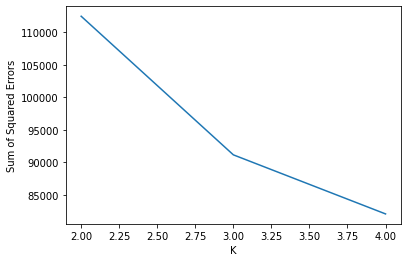

In [186]:
import time
start = time.time()
kprotos = run_kprototypes(absolute_final_speaker_features, start=2, end=4)
plot_sse(kprotos)
end = time.time()
print(f'The clustering took {(end - start) / 60} minutes')    

##### SAVE or LOAD the pre-processing until now:

In [142]:
# Save labels
for k in kprotos:
    with open(f'data/pickles/labels_for_{k}_cluster', 'wb') as f:
        pickle.dump(kprotos[k].labels_, f)

##### 2.2 Check distribution of elements among clusters

In [187]:
def print_cluster_labels(kprotos):
    """Print cluster labels to see distribution of elements among them."""
    for k, kproto in kprotos.items():
        print(f'k = {k} --> {Counter(kproto.labels_)}')
print_cluster_labels(kprotos)

k = 2 --> Counter({0: 174339, 1: 69565})
k = 3 --> Counter({0: 148910, 1: 69565, 2: 25429})
k = 4 --> Counter({2: 91428, 0: 69565, 3: 57482, 1: 25429})


In [188]:
def get_cluster_points(features, labels):
    """
    Given the features clustered over and the resulting labels, return dataframes
    where each dataframe contains the points of a label.
    -----
    Input: features - the dataframe which the clustering was run for
           labels   - the labels that each row of features received on clustering
    Returns:
           list_of_dfs - a list of dataframes, where each dataframe contains the points
                         of a same cluster label.
    """
    unique_classes = np.unique(labels)
    list_of_dfs = []
    for label in unique_classes:
        class_filter = np.equal(label, labels) * 1
        indices = np.nonzero(class_filter)
        df = features.iloc[indices]
        list_of_dfs.append(df)
    return list_of_dfs

clusters_for_k = get_cluster_points(speakers_features_preprocessed_final_really, kprotos[3].labels_)

##### SAVE or LOAD the clusters_for_k dataframes for each cluster:

In [116]:
# # Save
# for cluster_nr, cluster_df in enumerate(clusters_for_k):
#     cluster_df.to_csv(path_or_buf=f'data/pickles/cluster_{cluster_nr+1}.csv', index=True, encoding='utf-8')
# Load
# ...

##### SAVE the clusters and add a column saying to which cluster the row belongs to:

In [141]:
# Save dataframe containing qids and their cluster number
final_clusters_df = pd.DataFrame()
for cluster_nr, cluster_df in enumerate(clusters_for_k):
    cluster_df_copy = cluster_df.copy()
    cluster_df_copy['cluster_nr'] = cluster_nr + 1
    final_clusters_df = final_clusters_df.append(cluster_df_copy)
final_clusters_to_elliot = final_clusters_df.cluster_nr
final_clusters_to_elliot.to_csv(path_or_buf='data/pickles/final_clusters_to_elliot.csv', index=True, encoding='utf-8')

# Read as:
# final_clusters_to_elliot = pd.read_csv('data/pickles/final_clusters_to_elliot.csv')
# final_clusters_to_elliot.set_index('id', inplace=True)

<ipython-input-189-6e536224a76d>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axs[i].set_xticklabels(top_occupations_labels)


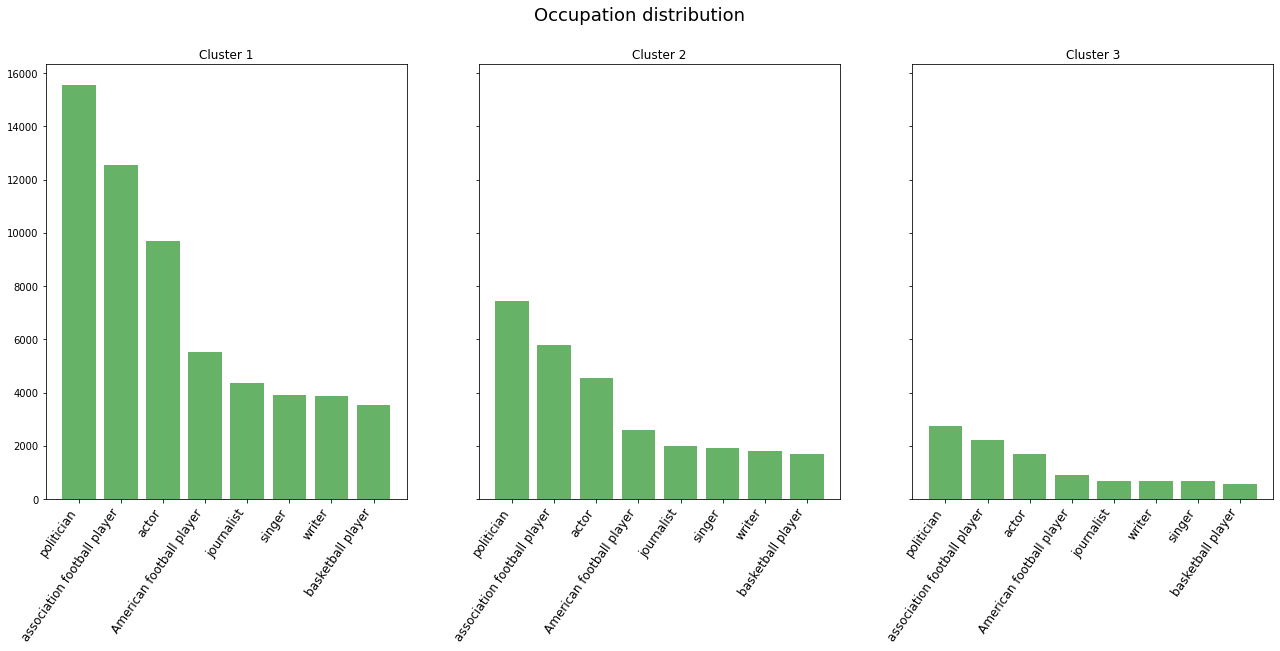

In [189]:
from qwikidata.linked_data_interface import get_entity_dict_from_api
import itertools

def plot_occupation_of_clusters(wikidata_speakers, clusters, nr_occupations=8):
    """
    Input: clusters - list of dataframes, where each dataframe contains points of the same cluster label.
    """
    nr_clusters = len(clusters)
    fig, axs = plt.subplots(1, nr_clusters, figsize=(22, 8), sharey=True)

    for i, df in enumerate(clusters):
        # Get the qids from the quotations df:
        qids = df.index.tolist()
        # Get the rows of the speakers having the wanted qids
        speakers = wikidata_speakers.loc[qids]
        # Get the speakers occupations and count them
        occupation_count = Counter(speakers.occupation.values)
        occupation_count_sorted = dict(sorted(occupation_count.items(), key=lambda x: x[1], reverse=True)) 
        top_occupations = dict(itertools.islice(occupation_count_sorted.items(), nr_occupations)) 
        # Query wikidata for occupation labels
        top_occupations_labels = [get_entity_dict_from_api(item)['labels']['en']['value'] for item in top_occupations.keys()]
        # Plot
        _ = axs[i].set_title(f'Cluster {i+1}')
        _ = axs[i].bar(top_occupations.keys(), top_occupations.values(), color='g', log=False, alpha=0.6)
        _ = axs[i].set_xticklabels(top_occupations_labels)
        _ = plt.setp(axs[i].get_xticklabels(), fontsize=12, rotation=55, ha='right')
    fig.suptitle('Occupation distribution', fontsize=18)

plot_occupation_of_clusters(speakers_features_final, clusters_for_k)

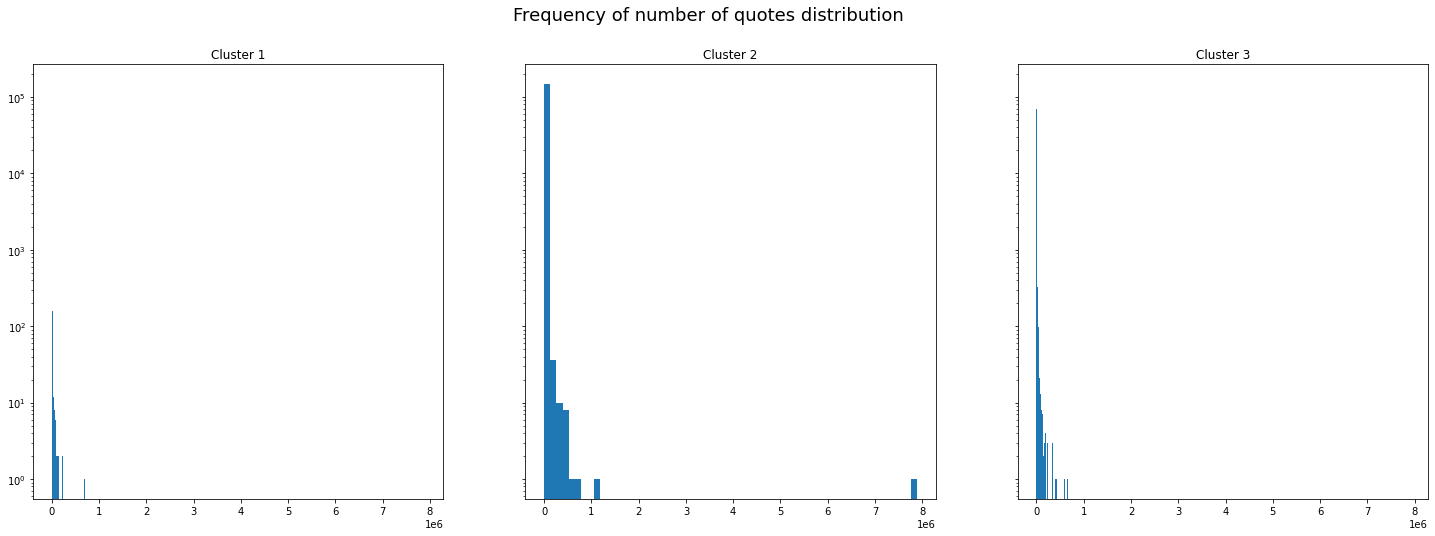

In [183]:
def plot_nr_quotes_of_clusters(clusters):
    # plt.bar(range(1, len(clusters) + 1), [cluster_df.n_quotes.sum() for cluster_df in clusters])
    # plt.xlabel('Cluster number')
    # plt.ylabel('Number of quotations')
    nr_clusters = len(clusters)
    fig, axs = plt.subplots(1, nr_clusters, figsize=(25, 8), sharex=True, sharey=True)
    for i, cluster_df in enumerate(clusters):
        axs[i].hist(cluster_df.n_quotes, bins=60, log=True)
        axs[i].set_title(f'Cluster {i+1}')
    fig.suptitle('Frequency of number of quotes distribution', fontsize=18)
    
plot_nr_quotes_of_clusters(clusters_for_k)

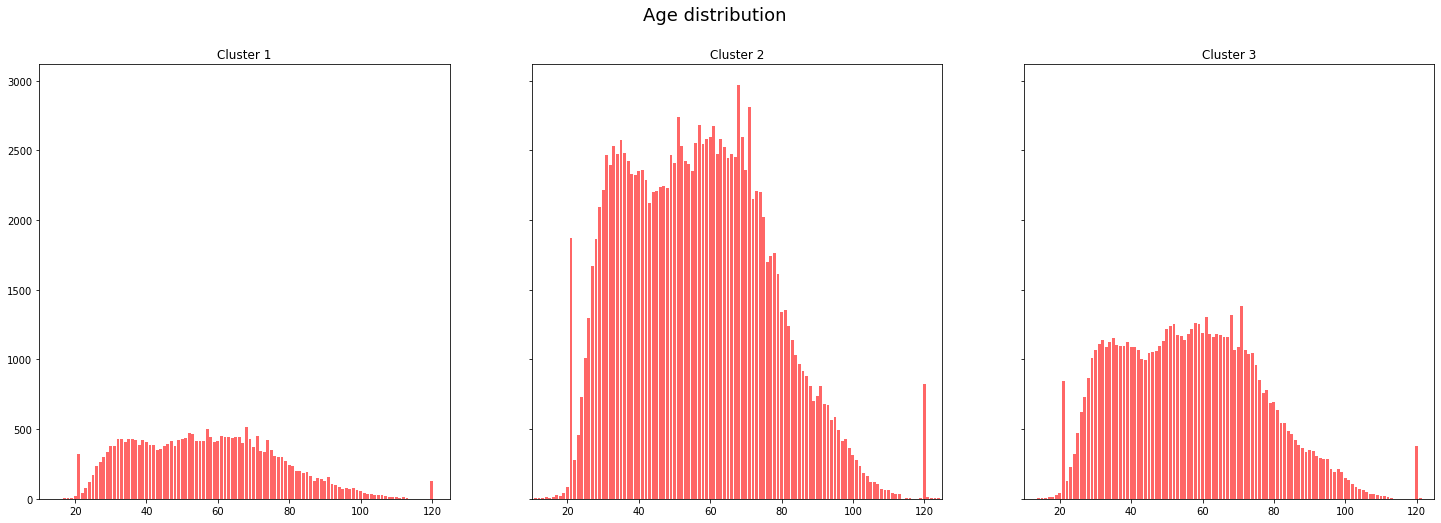

In [182]:
def plot_age_of_clusters(clusters):
    """
    Input: clusters - list of dataframes, where each dataframe contains points of the same cluster label.
    """
    nr_clusters = len(clusters)
    fig, axs = plt.subplots(1, nr_clusters, figsize=(25, 8), sharey=True)
    for i, cluster_df in enumerate(clusters):
        ages_count = Counter(cluster_df.age)
        # axs[i].hist(cluster_df.n_quotes, bins=30)
        _ = axs[i].set_title(f'Cluster {i+1}') 
        _ = axs[i].set_xlim(10, 125)
        _ = axs[i].bar(ages_count.keys(), ages_count.values(), color='r', alpha=0.6, width=0.8)
    fig.suptitle('Age distribution', fontsize=18)
    
plot_age_of_clusters(clusters_for_k)

In [181]:
# print(Counter(clusters_for_k[0].gender)) # 26% women
male_qid = 'Q6581097'
female_qid = 'Q6581072'
age_dist_cluster_1 = dict(Counter(clusters_for_k[0].gender))
age_dist_cluster_2 = dict(Counter(clusters_for_k[1].gender))
age_dist_cluster_3 = dict(Counter(clusters_for_k[2].gender))

def print_gender_dist(gender_dict, cluster_nr):
    print(f'Gender distribution in cluster {cluster_nr} \n -Men: {100*gender_dict[male_qid] / sum(gender_dict.values()):.2f}% \n -Women: {100*gender_dict[female_qid] / sum(gender_dict.values()):.2f}%')

print_gender_dist(age_dist_cluster_1, 1)
print_gender_dist(age_dist_cluster_2, 2)
print_gender_dist(age_dist_cluster_3, 3)


# print(Counter(clusters_for_k[1].gender)) # 51% women
# print(Counter(clusters_for_k[2].gender)) # 2.6% women

Gender distribution in cluster 1 
 -Men: 78.06% 
 -Women: 21.77%
Gender distribution in cluster 2 
 -Men: 78.23% 
 -Women: 21.61%
Gender distribution in cluster 3 
 -Men: 78.21% 
 -Women: 21.65%
